In [ ]:
!pip install -q --pre tf-agents[reverb]
!pip install -q 'gym==0.10.11'

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-agents 0.12.0 requires gym>=0.17.0, but you have gym 0.10.11 which is incompatible.


In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts


tf.compat.v1.enable_v2_behavior()

In [ ]:
FOOD = 3
HEAD = 2
BODY = 1
EMPTY = 0

class SnakeEnv(py_environment.PyEnvironment):

  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=3, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(1, 20, 20), dtype=np.int32, minimum=0, maximum=3, name='observation')
    self._head = (10, 10)
    self._snake = [self._head, (9, 10)]
    self._food = (12, 10)
    self._grid = [[0 for i in range(20)] for j in range(20)]
    self._grid[self._head[1] - 1][self._head[0] - 1] = HEAD
    self._grid[self._food[1] - 1][self._food[0] - 1] = FOOD
    self._grid[self._snake[1][1] - 1][self._snake[1][0] - 1] = BODY
    self._fed = False
    self._moves = 0
    self._survival_time = 0
    self._episode_ended = False

  def action_spec(self):
    return self._action_spec
  
  def render(self):
    dis = [[[0, 0, 0] for i in range(640)] for j in range(640)]
    for i in range(len(self._grid)):
      for j in range(len(self._grid[0])):
        if self._grid[i][j] == 3:
          for m in range(32):
            for n in range(32):
              dis[32*i+m][32*j+n] = [255, 0, 0]
        elif self._grid[i][j] == 2:
          for m in range(32):
            for n in range(32):
              dis[32*i+m][32*j+n] = [100, 255, 100]
        elif self._grid[i][j] == 1:
          for m in range(32):
            for n in range(32):
              dis[32*i+m][32*j+n] = [0, 255, 0]
        else:
          for m in range(32):
            for n in range(32):
              dis[32*i+m][32*j+n] = [255, 255, 255]
    rt = np.asarray(dis, dtype=np.uint8)
    return rt


  def observation_spec(self):
    return self._observation_spec

  def _reset(self):
    self._head = (10, 10)
    self._snake = [self._head, (9, 10)]
    self._food = (12, 10)
    self._grid = [[0 for i in range(20)] for j in range(20)]
    self._grid[self._head[1] - 1][self._head[0] - 1] = HEAD
    self._grid[self._food[1] - 1][self._food[0] - 1] = FOOD
    self._grid[self._snake[1][1] - 1][self._snake[1][0] - 1] = BODY
    self._episode_ended = False
    self._moves = 0
    self._survival_time = 0
    return ts.restart(np.array([self._grid], dtype=np.int32))

  def _step(self, action):
    self._moves += 1
    self._survival_time += 1

    if self._episode_ended:
      # The last action ended the episode. Ignore the current action and start
      # a new episode.
      return self.reset()

    # Make sure episodes don't go on forever.
    if action == 0: # move right
      if self._snake[1] != (self._head[0] + 1, self._head[1]):
        self._head = (self._head[0] + 1, self._head[1])
      else:
        self._head = (self._head[0] - 1, self._head[1])

    elif action == 1: # move left
      if self._snake[1] != (self._head[0] - 1, self._head[1]):
        self._head = (self._head[0] - 1, self._head[1])
      else:
        self._head = (self._head[0] + 1, self._head[1])

    elif action == 2: # move up
      if self._snake[1] != (self._head[0], self._head[1] + 1):
        self._head = (self._head[0], self._head[1] + 1)
      else:
        self._head = (self._head[0], self._head[1] - 1)

    elif action == 3: # move down
      if self._snake[1] != (self._head[0], self._head[1] - 1):
        self._head = (self._head[0], self._head[1] - 1)
      else:
        self._head = (self._head[0], self._head[1] + 1)

    else:
      raise ValueError('`action` should between 0 and 3.')

    
    dist = abs(self._food[0] - self._head[0]) + abs(self._food[1] - self._head[1])
    wall = abs(10 - self._head[0]) + abs(10 - self._head[1])
    
    for i in range(len(self._snake) - 2) :
      if i == self._head:
        self._episode_ended = True
    
    if not 0 <= self._head[0] <= 20 or not 0 <= self._head[1] <= 20:
      self._episode_ended = True

    if self._moves > 800:
      self._episode_ended = True
    
    if self._head == self._food:
      self._fed = True
      self._moves = 0
      # grow snake
      self._snake.append([len(self._snake) - 1])
      # move food
      while self._food in self._snake or self._food == self._head:
        self._food = (np.random.randint(1, 21), np.random.randint(1, 21))

    # move snake
    for i in range(len(self._snake) - 1, 0, -1):
      self._snake[i] = self._snake[i - 1]
    self._snake[0] = self._head
    
    if not self._episode_ended:
      self._grid = [[0 for i in range(20)] for j in range(20)]
      self._grid[self._head[1] - 1][self._head[0] - 1] = HEAD
      self._grid[self._food[1] -1 ][self._food[0] - 1 ] = FOOD
      for i in range(len(self._snake) - 1, 0, -1):
        self._grid[self._snake[i][1] - 1][self._snake[i][0] - 1] = BODY

    reward = len(self._snake) * (40 - dist + self._survival_time - self._moves - wall)
    
    if self._episode_ended:
      return ts.termination(np.array([self._grid], dtype=np.int32), reward)
    else:
      if self._fed:
        self._fed = False
      #else:
        # reward = reward - dist - self._moves
      return ts.transition(
          np.array([self._grid], dtype=np.int32), reward, discount=1)

In [ ]:
environment = SnakeEnv()
utils.validate_py_environment(environment, episodes=5)

In [ ]:
go_right = np.array(0, dtype=np.int32)

environment = SnakeEnv()
time_step = environment.reset()
print(time_step)
cumulative_reward = time_step.reward

for _ in range(10):
  time_step = environment.step(go_right)
  print(time_step)
  cumulative_reward += time_step.reward

time_step = environment.step(go_right)
print(time_step)
cumulative_reward += time_step.reward
print('Final Reward = ', cumulative_reward)

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0

In [ ]:
environment.reset()

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0

In [ ]:
!sudo apt-get install -y xvfb ffmpeg
!pip install -q 'gym==0.10.11'
!pip install -q 'imageio==2.4.0'
!pip install -q PILLOW
!pip install -q 'pyglet==1.3.2'
!pip install -q pyvirtualdisplay
!pip install -q tf-agents

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

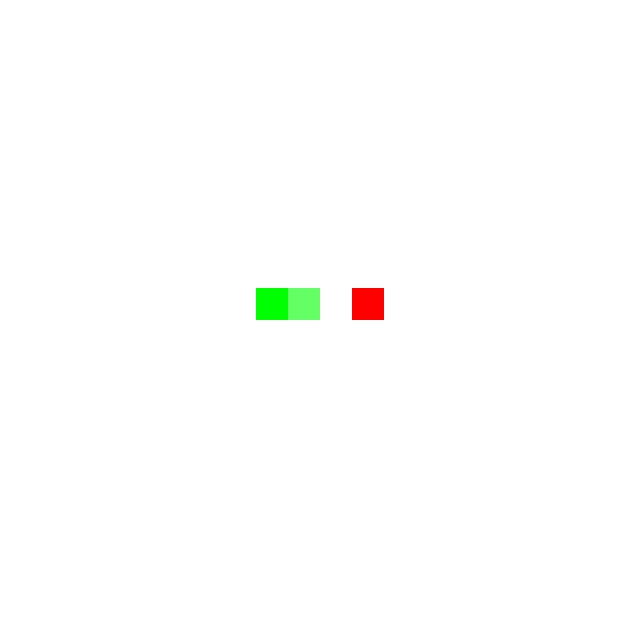

In [ ]:
PIL.Image.fromarray(environment.render(), mode='RGB')
#display(img.resize((256, 256), PIL.Image.LANCZOS))

In [ ]:
num_iterations = 50000 # @param {type:"integer"}//50000 initially

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-4  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

In [ ]:
env = environment

print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [ ]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int32'), name='action', minimum=0, maximum=3)


In [ ]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0,

In [ ]:
train_py_env = SnakeEnv()
eval_py_env = SnakeEnv()

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [ ]:
fc_layer_params = (100,)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

In [ ]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [ ]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [ ]:
from tf_agents.policies import policy_saver
tf_policy_saver = policy_saver.PolicySaver(collect_policy)

In [ ]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [ ]:
example_environment = tf_py_environment.TFPyEnvironment(
    SnakeEnv())

In [ ]:
time_step = example_environment.reset()

In [ ]:
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>, state=(), info=())

In [ ]:

def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

In [ ]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

2238.2

In [ ]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

In [ ]:
agent.collect_data_spec

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(3, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(1, 20, 20), dtype=tf.int32, name='observation', minimum=array(0, dtype=int32), maximum=array(3, dtype=int32)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [ ]:

def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, steps=100)

# This loop is so common in RL, that we provide standard implementations. 
# For more details see the drivers module.
# https://www.tensorflow.org/agents/api_docs/python/tf_agents/drivers

In [ ]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)


dataset

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


<PrefetchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 1, 20, 20), dtype=tf.int32, name=None),
 'policy_info': (),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)}), BufferInfo(ids=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), probabilities=TensorSpec(shape=(64,), dtype=tf.float32, name=None)))>

In [ ]:
iterator = iter(dataset)

print(iterator)


In [ ]:

try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy, replay_buffer)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step = 200: loss = 2514.2001953125
step = 400: loss = 1923.447021484375
step = 600: loss = 2669.627197265625
step = 800: loss = 2214.989013671875
step = 1000: loss = 2753.41552734375
step = 1000: Average Return = 572.0
step = 1200: loss = 2467.385986328125
step = 1400: loss = 2703.607421875
step = 1600: loss = 2280.0029296875
step = 1800: loss = 2561.79541015625
step = 2000: loss = 2933.3154296875
step = 2000: Average Return = 572.0
step = 2200: loss = 2889.8505859375
step = 2400: loss = 3013.6064453125
step = 2600: loss = 3457.708251953125
step = 2800: loss = 2603.0302734375
step = 3000: loss = 3084.70849609375
step = 3000: Average Return = 572.0
step = 3200: loss = 2867.974609375
step = 3400: loss = 3114.212890625
step = 3600: loss = 3175.96435546875
step = 3800: loss = 3087.25244140625
step = 4000: loss = 3672.8251953125
step = 4000: Average Return = 572.0
step = 4200: loss = 3194.206298828125
step = 4400: loss = 3004.530517578125
step = 4600: loss = 3368.31103515625
step = 4800: lo

Text(0.5, 0, 'Iterations')

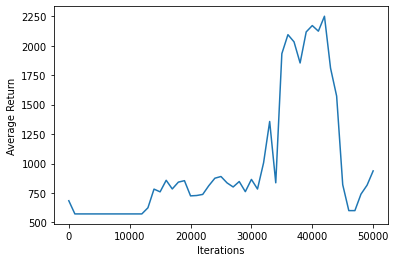

In [ ]:


iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [ ]:
def create_policy_eval_video(policy, filename, num_episodes=1, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)




create_policy_eval_video(agent.policy, "trained-agent")

In [ ]:
create_policy_eval_video(random_policy, "random-agent")

# New Section

In [ ]:
import os
checkpoint_dir = os.path.join('checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer,
    global_step=train_step_counter#global_step
)

In [ ]:
policy_dir = os.path.join( 'policy')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)

In [ ]:
train_checkpointer.save(train_step_counter)#global_step

In [ ]:
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
tempdir=os.path.join('/content/gdrive/MyDrive/ai_project')
tf_policy_saver.save(tempdir)

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/ai_project/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:524: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/ai_project/assets


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(tempdir, signature_keys=["action"])
tflite_policy = converter.convert()
with open(os.path.join(tempdir, 'policy.tflite'), 'wb') as f:
  f.write(tflite_policy)

In [ ]:
import numpy as np
interpreter = tf.lite.Interpreter(os.path.join(tempdir, 'policy.tflite'))

policy_runner = interpreter.get_signature_runner()
print(policy_runner._inputs)

{'0/discount': 1, '0/observation': 2, '0/reward': 3, '0/step_type': 0}


In [ ]:
policy_runner(**{
    '0/discount':tf.constant(0.0),
    '0/observation':tf.zeros([1,4]),
    '0/reward':tf.constant(0.0),
    '0/step_type':tf.constant(0)})

RuntimeError: ignored